# `Modeling`



In [1]:
#pip install xgboost

`import necessary libraries`

In [2]:
# Import necessary libraries
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.combine import SMOTETomek
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random 


In [3]:
provider = pd.read_csv('provider.csv')
provider.drop(provider.columns[0], axis=1, inplace=True)
provider.head()

,Provider,inp_out,inp_out.1,ClmAdmitDiagnosisCode,DiagnosisGroupCode,AttendingPhysician,OperatingPhysician,OtherPhysician,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,settlement_days.1,Days_Admit,Total_deductible,Total_deductible.1,Total_reimbursible,Total_reimbursible.1,ClaimID,State,County,PotentialFraud
0,PRV51001,20,5,11,5,14,5,8,15,19,...,0,1.000000,1361.040000,34026,20221.200000,505530,25,1,7,0
1,PRV51003,70,62,58,58,44,7,22,56,80,...,0,2.424242,1668.545455,220248,10246.363636,1352520,132,3,23,1
2,PRV51004,149,0,25,0,38,19,26,64,88,...,0,0.000000,1057.704698,157598,6546.778523,975470,149,9,28,0
3,PRV51005,1164,0,158,0,6,6,4,426,679,...,0,0.000000,1013.544674,1179766,5531.168385,6438280,1165,4,26,1
4,PRV51007,69,3,17,3,10,5,7,26,40,...,0,0.222222,914.722222,65860,4779.722222,344140,72,2,6,0


In [4]:
provider.columns

Index(['Provider', 'inp_out', 'inp_out.1', 'ClmAdmitDiagnosisCode',
       'DiagnosisGroupCode', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'Gender', 'RenalDiseaseIndicator',
       'InscClaimAmtReimbursed', 'InscClaimAmtReimbursed.1',
       'IPAnnualReimbursementAmt', 'IPAnnualReimbursementAmt.1',
       'IPAnnualDeductibleAmt', 'IPAnnualDeductibleAmt.1',
       'OPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt.2', 'Age',
       'settlement_days', 'settlement_days.1', 'Days_Admit',
       'Total_deductible', 'Total_deductible.1', 'Total_reimbursible',
       'Total_reimbursible.1', 'ClaimID', 'State', 'County', 'PotentialFraud'],


 Train-Test Split for Potential Fraud Prediction

In [5]:

# Perform train-test split for potential fraud prediction
X = provider.drop(columns = ['PotentialFraud', 'Provider'], axis = 1)
y = provider['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4328, 39)
X_test shape: (1082, 39)
y_train shape: (4328,)
y_test shape: (1082,)


Creating functions 


In [6]:
def create_model(X_train, y_train, X_test, classifier):
    """Function that takes in the data, creates the model using the classifier, and performs prediction"""
    # Instantiate the model
    model = classifier 
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    return model, y_pred

In [7]:
#function for evaluation metrics 
def evaluation(y_test, y_pred):
    """
    A function to print evaluation metrics and classification report of a model
    """
    auc = roc_auc_score(y_test, y_pred)
    print(f"The model has an AUC score of {auc:.2%}")
    print("-----------------------------------------------")
    print(f"The model's recall rate is {recall_score(y_test, y_pred, average='weighted'):.2%}")
    print("-----------------------------------------------")
    print(f"The model's precision is {precision_score(y_test, y_pred, average='weighted'):.2%}")
    print("-----------------------------------------------")
    print(f"The model's F1 score is {f1_score(y_test, y_pred, average='weighted'):.2%}")
    print("-----------------------------------------------")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

In [8]:
def display_confusion_matrix(y_test, y_pred, cmap='GnBu'):
    """Display confusion matrix"""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['not_fraud', 'fraud'],
           yticklabels=['not_fraud', 'fraud'],
           xlabel='Predicted label',
           ylabel='True label',
           title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = '.4g'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "darkblue")
    ax.grid(False)
    fig.tight_layout()
    plt.show()

In [9]:
def plot_roc_curve(model, X_test, y_test):
    """Plot ROC curve for a binary classification model"""
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]  # Use predict_proba if available
    else:
        y_score = model.decision_function(X_test)  # Use decision_function as an alternative
    
    # Calculate False Positive Rate (FPR) and True Positive Rate (TPR) using roc_curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [10]:
model, y_pred = create_model(X_train, y_train, X_test, classifier=KNeighborsClassifier())
evaluation(y_test, y_pred)

The model has an AUC score of 68.50%
-----------------------------------------------
The model's recall rate is 92.24%
-----------------------------------------------
The model's precision is 91.16%
-----------------------------------------------
The model's F1 score is 91.29%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       977
           1       0.67      0.39      0.49       105

    accuracy                           0.92      1082
   macro avg       0.80      0.69      0.73      1082
weighted avg       0.91      0.92      0.91      1082



## `Baseline Model`

#### Building a random model

In [11]:
train_data_len = X_train.shape[0]

# Define the list of possible output values
op_list = [0, 1]

# Initialize an array to store the predicted values
train_predicted_y = np.zeros(train_data_len)

# Generate random predictions for the training set
for i in range(train_data_len):
    train_predicted_y[i] = random.choice(op_list)

# Evaluate the performance of the random model on the training set
train_accuracy = np.mean(train_predicted_y == y_train)
print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))

# Generate random predictions for the test set
test_data_len = X_test.shape[0]
test_predicted_y = np.zeros(test_data_len)
for i in range(test_data_len):
    test_predicted_y[i] = random.choice(op_list)

# Evaluate the performance of the random model on the test set
test_accuracy = np.mean(test_predicted_y == y_test)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Training Accuracy: 51.25%
Test Accuracy: 50.46%


### `Checking and Handling Class Imbalance`

#### Sampling Techniques 

- Undersampling technique

- oversampling technique

- Hybrid sampling technique

In [12]:
# undersampling technique
from imblearn.under_sampling import NearMiss
from collections import Counter

# Create an instance of NearMiss with a sampling ratio of 0.8
ns = NearMiss(sampling_strategy=0.8)

# Apply undersampling to the training data
x_train_ns, y_train_ns = ns.fit_resample(X_train, y_train)

# Print the class distribution before and after undersampling
print("The number of classes before fit: {}".format(Counter(y_train)))
print("The number of classes after fit: {}".format(Counter(y_train_ns)))


The number of classes before fit: Counter({0: 3927, 1: 401})
The number of classes after fit: Counter({0: 501, 1: 401})


`Decision Tree with undersampling`

In [13]:
model, y_pred = create_model(x_train_ns, y_train_ns, X_test, classifier=DecisionTreeClassifier(random_state=42))


In [14]:
evaluation(y_test, y_pred)

The model has an AUC score of 61.67%
-----------------------------------------------
The model's recall rate is 40.76%
-----------------------------------------------
The model's precision is 88.29%
-----------------------------------------------
The model's F1 score is 49.23%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.36      0.52       977
           1       0.13      0.88      0.22       105

    accuracy                           0.41      1082
   macro avg       0.55      0.62      0.37      1082
weighted avg       0.88      0.41      0.49      1082



`Random Forest with undersampling`

In [15]:
model, y_pred = create_model(x_train_ns, y_train_ns, X_test, classifier=RandomForestClassifier(random_state=42))


In [16]:
evaluation(y_test, y_pred)

The model has an AUC score of 68.90%
-----------------------------------------------
The model's recall rate is 53.05%
-----------------------------------------------
The model's precision is 89.63%
-----------------------------------------------
The model's F1 score is 61.69%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.49      0.65       977
           1       0.16      0.89      0.27       105

    accuracy                           0.53      1082
   macro avg       0.57      0.69      0.46      1082
weighted avg       0.90      0.53      0.62      1082



In [17]:
# oversampling technique

from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# Assuming X_train and y_train are defined and assigned values correctly

os = RandomOverSampler(sampling_strategy=0.75)
x_train_os, y_train_os = os.fit_resample(X_train, y_train)

print("The number of classes before fit: {}".format(Counter(y_train)))
print("The number of classes after fit: {}".format(Counter(y_train_os)))


The number of classes before fit: Counter({0: 3927, 1: 401})
The number of classes after fit: Counter({0: 3927, 1: 2945})


`Decision tree with oversampling technique`

In [18]:
model, y_pred = create_model(x_train_os, y_train_os, X_test, classifier=DecisionTreeClassifier(random_state=42))


In [19]:
evaluation(y_test, y_pred)

The model has an AUC score of 69.19%
-----------------------------------------------
The model's recall rate is 89.65%
-----------------------------------------------
The model's precision is 89.39%
-----------------------------------------------
The model's F1 score is 89.51%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       977
           1       0.46      0.44      0.45       105

    accuracy                           0.90      1082
   macro avg       0.70      0.69      0.70      1082
weighted avg       0.89      0.90      0.90      1082



`random forest with over sampling technique`

In [20]:
model, y_pred = create_model(x_train_os, y_train_os, X_test, classifier=RandomForestClassifier(random_state=42))


In [21]:
evaluation(y_test, y_pred)

The model has an AUC score of 72.07%
-----------------------------------------------
The model's recall rate is 91.77%
-----------------------------------------------
The model's precision is 91.10%
-----------------------------------------------
The model's F1 score is 91.36%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       977
           1       0.60      0.48      0.53       105

    accuracy                           0.92      1082
   macro avg       0.77      0.72      0.74      1082
weighted avg       0.91      0.92      0.91      1082



`Hybrid sampling technique`

In [22]:
st = SMOTETomek()
x_train_st, y_train_st = st.fit_resample(X_train, y_train)

print("The number of classes before fit: {}".format(Counter(y_train)))
print("The number of classes after fit: {}".format(Counter(y_train_st)))

The number of classes before fit: Counter({0: 3927, 1: 401})
The number of classes after fit: Counter({0: 3881, 1: 3881})


`Decision tree Hybrid sampling technique`

In [23]:
model, y_pred = create_model(x_train_st, y_train_st, X_test, classifier=DecisionTreeClassifier(random_state=42))


In [24]:
evaluation(y_test, y_pred)

The model has an AUC score of 75.51%
-----------------------------------------------
The model's recall rate is 87.25%
-----------------------------------------------
The model's precision is 90.13%
-----------------------------------------------
The model's F1 score is 88.40%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       977
           1       0.40      0.61      0.48       105

    accuracy                           0.87      1082
   macro avg       0.68      0.76      0.70      1082
weighted avg       0.90      0.87      0.88      1082



`Random Forest hybrid sampling technique`

In [25]:
model, y_pred = create_model(x_train_st, y_train_st, X_test, classifier=RandomForestClassifier(random_state=42))


In [26]:
evaluation(y_test, y_pred)

The model has an AUC score of 79.70%
-----------------------------------------------
The model's recall rate is 90.20%
-----------------------------------------------
The model's precision is 91.75%
-----------------------------------------------
The model's F1 score is 90.83%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       977
           1       0.50      0.67      0.57       105

    accuracy                           0.90      1082
   macro avg       0.73      0.80      0.76      1082
weighted avg       0.92      0.90      0.91      1082



Scaling the Numerical Features 


In [27]:
from sklearn.preprocessing import StandardScaler

# Instantiate the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(x_train_st)
X_test_scaled = scaler.transform(X_test)

## 2. `KNN Model`

In [28]:
model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=KNeighborsClassifier())
evaluation(y_test, y_pred)

The model has an AUC score of 80.01%
-----------------------------------------------
The model's recall rate is 83.09%
-----------------------------------------------
The model's precision is 90.88%
-----------------------------------------------
The model's F1 score is 85.75%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       977
           1       0.34      0.76      0.47       105

    accuracy                           0.83      1082
   macro avg       0.65      0.80      0.68      1082
weighted avg       0.91      0.83      0.86      1082



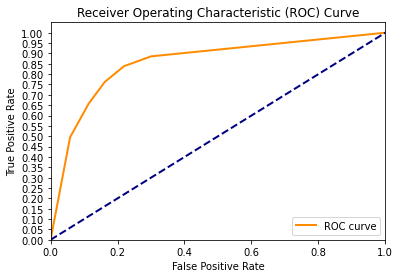

In [29]:

plot_roc_curve(model, X_test_scaled, y_test)

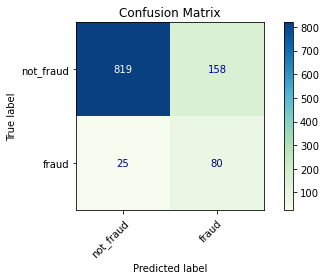

In [30]:

display_confusion_matrix(y_test, y_pred)

## 3. `Decision Trees Model`

In [31]:
model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=DecisionTreeClassifier(random_state=42))

evaluation(y_test, y_pred)

The model has an AUC score of 75.51%
-----------------------------------------------
The model's recall rate is 87.25%
-----------------------------------------------
The model's precision is 90.13%
-----------------------------------------------
The model's F1 score is 88.40%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       977
           1       0.40      0.61      0.48       105

    accuracy                           0.87      1082
   macro avg       0.68      0.76      0.70      1082
weighted avg       0.90      0.87      0.88      1082



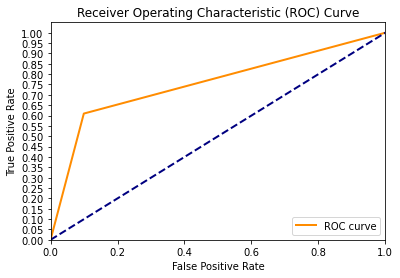

In [32]:

plot_roc_curve(model, X_test_scaled, y_test)

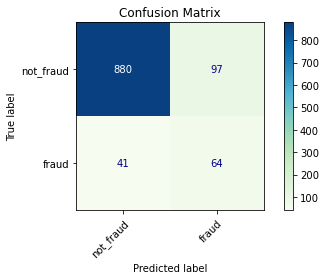

In [33]:

display_confusion_matrix(y_test, y_pred)

## 4. `SVM`

In [34]:
model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=SVC(random_state=42))
evaluation(y_test, y_pred)

The model has an AUC score of 85.03%
-----------------------------------------------
The model's recall rate is 86.78%
-----------------------------------------------
The model's precision is 92.41%
-----------------------------------------------
The model's F1 score is 88.63%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       977
           1       0.41      0.83      0.55       105

    accuracy                           0.87      1082
   macro avg       0.69      0.85      0.74      1082
weighted avg       0.92      0.87      0.89      1082



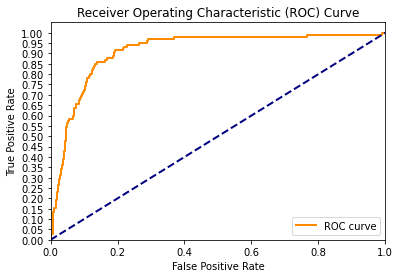

In [35]:
plot_roc_curve(model, X_test_scaled, y_test)

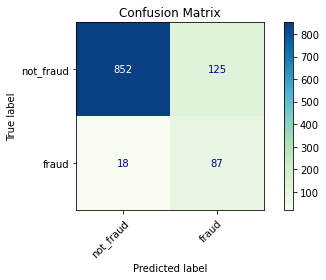

In [36]:
display_confusion_matrix(y_test, y_pred)

## 5. `Gradientboost model`

In [37]:

model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=GradientBoostingClassifier(random_state=42))
evaluation(y_test, y_pred)

The model has an AUC score of 84.86%
-----------------------------------------------
The model's recall rate is 87.25%
-----------------------------------------------
The model's precision is 92.41%
-----------------------------------------------
The model's F1 score is 88.96%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       977
           1       0.42      0.82      0.55       105

    accuracy                           0.87      1082
   macro avg       0.70      0.85      0.74      1082
weighted avg       0.92      0.87      0.89      1082



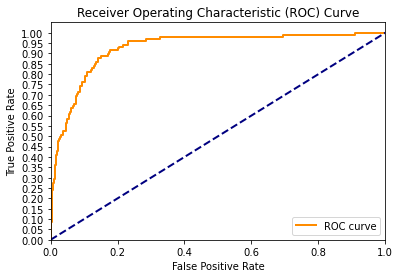

In [38]:

plot_roc_curve(model, X_test_scaled, y_test)

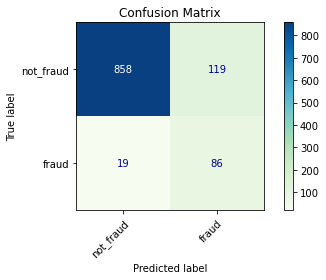

In [39]:

display_confusion_matrix(y_test, y_pred)

## 5. `Logistic regression Model`

In [40]:
model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=LogisticRegression(random_state=42))
evaluation(y_test, y_pred)

The model has an AUC score of 82.67%
-----------------------------------------------
The model's recall rate is 87.89%
-----------------------------------------------
The model's precision is 91.95%
-----------------------------------------------
The model's F1 score is 89.32%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       977
           1       0.43      0.76      0.55       105

    accuracy                           0.88      1082
   macro avg       0.70      0.83      0.74      1082
weighted avg       0.92      0.88      0.89      1082



c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


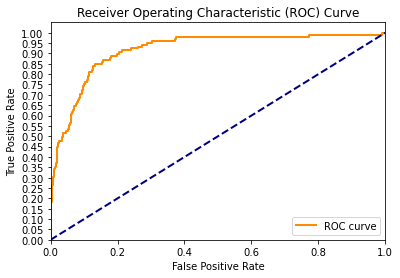

In [41]:
plot_roc_curve(model, X_test_scaled, y_test)


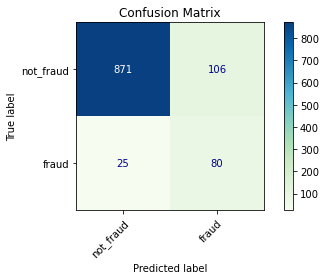

In [42]:
display_confusion_matrix(y_test, y_pred)

## 6. `XGBoost`

In [43]:
model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=XGBClassifier(random_state=42))

In [44]:
evaluation(y_test, y_pred)

The model has an AUC score of 77.27%
-----------------------------------------------
The model's recall rate is 89.65%
-----------------------------------------------
The model's precision is 91.08%
-----------------------------------------------
The model's F1 score is 90.25%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       977
           1       0.47      0.62      0.54       105

    accuracy                           0.90      1082
   macro avg       0.72      0.77      0.74      1082
weighted avg       0.91      0.90      0.90      1082



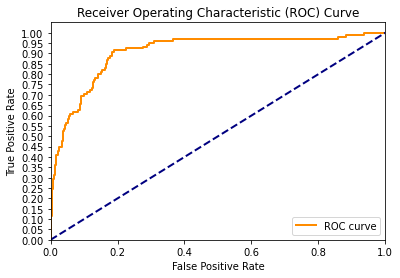

In [45]:
plot_roc_curve(model, X_test_scaled, y_test)

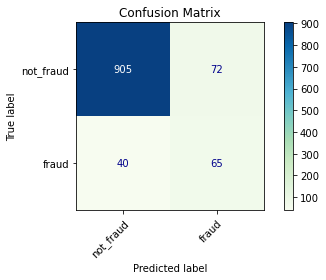

In [46]:
display_confusion_matrix(y_test, y_pred)

hypertuning 

In [47]:
class XGBoostModel:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.best_estimator = None
    
    def train_best_estimator(self, X_train, y_train):
        self.best_estimator = XGBClassifier(subsample=1, n_estimators=100, max_depth=3, colsample_bytree=1, learning_rate=0.1, random_state=self.random_state)
        self.best_estimator.fit(X_train, y_train)
    
    def evaluate_best_estimator(self, X_test, y_test):
        y_pred_proba = self.best_estimator.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        y_pred_binary = (y_pred_proba >= 0.5).astype(int)
        recall = recall_score(y_test, y_pred_binary, average='weighted')
        precision = precision_score(y_test, y_pred_binary, average='weighted')
        f1 = f1_score(y_test, y_pred_binary, average='weighted')
        print(f"The model has an AUC score of {auc:.2%}")
        print("-----------------------------------------------")
        print(f"The model's recall rate is {recall:.2%}")
        print("-----------------------------------------------")
        print(f"The model's precision is {precision:.2%}")
        print("-----------------------------------------------")
        print(f"The model's F1 score is {f1:.2%}")
        print("-----------------------------------------------")
        print("Classification Report:")
        print(classification_report(y_test, y_pred_binary))
    
    def display_confusion_matrix(self, X_test, y_test):
        y_pred = self.best_estimator.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.matshow(cm, cmap=plt.cm.Blues)
        plt.colorbar()
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.xticks([0, 1], ['Negative', 'Positive'])
        plt.yticks([0, 1], ['Negative', 'Positive'])
        plt.title('Confusion matrix')
        plt.show()

In [48]:
# Instantiate the XGBoostModel class
model = XGBoostModel(random_state=42)

# Train the model
model.train_best_estimator(X_train_scaled, y_train_st)


In [49]:
# Evaluate the model
model.evaluate_best_estimator(X_test_scaled, y_test)

The model has an AUC score of 92.30%
-----------------------------------------------
The model's recall rate is 87.15%
-----------------------------------------------
The model's precision is 92.07%
-----------------------------------------------
The model's F1 score is 88.83%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       977
           1       0.41      0.79      0.54       105

    accuracy                           0.87      1082
   macro avg       0.70      0.84      0.73      1082
weighted avg       0.92      0.87      0.89      1082



## 7. `Random Forest Model`

In [50]:

model, y_pred = create_model(X_train_scaled, y_train_st, X_test_scaled, classifier=RandomForestClassifier(random_state=42))
evaluation(y_test, y_pred)

The model has an AUC score of 79.70%
-----------------------------------------------
The model's recall rate is 90.20%
-----------------------------------------------
The model's precision is 91.75%
-----------------------------------------------
The model's F1 score is 90.83%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       977
           1       0.50      0.67      0.57       105

    accuracy                           0.90      1082
   macro avg       0.73      0.80      0.76      1082
weighted avg       0.92      0.90      0.91      1082



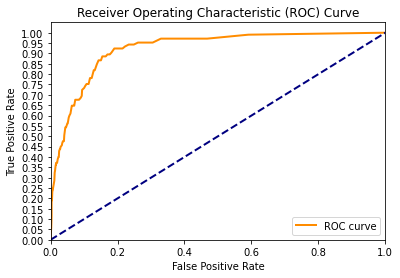

In [51]:
plot_roc_curve(model, X_test_scaled, y_test)


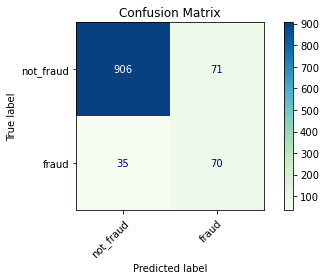

In [52]:
display_confusion_matrix(y_test, y_pred)

In [53]:
class RandomForestModel:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.model = None
    
    def train(self, X_train, y_train):
        self.model = RandomForestClassifier(random_state=self.random_state)
        self.model.fit(X_train, y_train)
    
    def evaluate(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        self.evaluation(y_test, y_pred)
        return y_pred
    
    def tune_hyperparameters(self, X_train, y_train):
        # Define the parameter grid
        param_grid = {
            'n_estimators': [100, 200, 500],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }
        
        # Create a GridSearchCV object
        grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=self.random_state), param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)
        
        # Fit the GridSearchCV object to the training data
        grid_search.fit(X_train, y_train)
        
        # Get the best estimator
        self.model = grid_search.best_estimator_
    
    def evaluation(self, y_true, y_pred):
        auc_score = roc_auc_score(y_true, y_pred)
        print(f"The model has an AUC score of {auc_score*100:.2f}%")
        print("-----------------------------------------------")
        
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1_score = 2 * (precision * recall) / (precision + recall)
        print(f"The model's recall rate is {recall*100:.2f}%")
        print("-----------------------------------------------")
        print(f"The model's precision is {precision*100:.2f}%")
        print("-----------------------------------------------")
        print(f"The model's F1 score is {f1_score*100:.2f}%")
        print("-----------------------------------------------")
        print("Classification Report:")
        print(classification_report(y_true, y_pred))
    
    def plot_roc_curve(self, X_test, y_test):
        y_pred_proba = self.model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend()
        plt.show()
    
    def display_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.matshow(cm, cmap=plt.cm.Blues)
        plt.colorbar()
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.xticks([0, 1], ['Negative', 'Positive'])
        plt.yticks([0, 1], ['Negative', 'Positive'])
        plt.title('Confusion matrix')
        plt.show()

In [54]:
model = RandomForestModel(random_state=42)
model.train(X_train_scaled, y_train_st)

In [55]:
y_pred = model.evaluate(X_test_scaled, y_test)

The model has an AUC score of 79.70%
-----------------------------------------------
The model's recall rate is 66.67%
-----------------------------------------------
The model's precision is 49.65%
-----------------------------------------------
The model's F1 score is 56.91%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       977
           1       0.50      0.67      0.57       105

    accuracy                           0.90      1082
   macro avg       0.73      0.80      0.76      1082
weighted avg       0.92      0.90      0.91      1082



In [57]:
model.tune_hyperparameters(X_train_scaled, y_train_st)

In [ ]:
y_pred_tuned = model.evaluate(X_test, y_test)

In [ ]:

model.plot_roc_curve(X_test, y_test)
model.display_confusion_matrix(y_test, y_pred_tuned)

In [ ]:
from xgboost import XGBClassifier
xgb_tuned = XGBClassifier(subsample=1,n_estimators= 100,max_depth= 3,colsample_bytree=1,learning_rate= 0.1)
xgb_tuned.fit(X_train_scaled, y_train_st)

train_y_pred = xgb_tuned.predict_proba(X_train_scaled)
train_y_pred = train_y_pred[:,1]


In [ ]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, classification_report

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
train_y_pred_binary = (train_y_pred >= 0.5).astype(int)

# Calculate evaluation metrics
auc = roc_auc_score(y_train_st, train_y_pred)
recall = recall_score(y_train_st, train_y_pred_binary, average='weighted')
precision = precision_score(y_train_st, train_y_pred_binary, average='weighted')
f1 = f1_score(y_train_st, train_y_pred_binary, average='weighted')

# Print evaluation metrics
print(f"The model has an AUC score of {auc:.2%}")
print("-----------------------------------------------")
print(f"The model's recall rate is {recall:.2%}")
print("-----------------------------------------------")
print(f"The model's precision is {precision:.2%}")
print("-----------------------------------------------")
print(f"The model's F1 score is {f1:.2%}")
print("-----------------------------------------------")

# Print classification report
print("Classification Report:")
print(classification_report(y_train_st, train_y_pred_binary))


The model has an AUC score of 97.96%
-----------------------------------------------
The model's recall rate is 93.39%
-----------------------------------------------
The model's precision is 93.49%
-----------------------------------------------
The model's F1 score is 93.39%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      3632
           1       0.91      0.96      0.94      3632

    accuracy                           0.93      7264
   macro avg       0.93      0.93      0.93      7264
weighted avg       0.93      0.93      0.93      7264

